# Using the first-order-plus-dead-time model and idenitifying it

In [1]:
from homeheating import HeatingModel
import numpy as np
from gekko import GEKKO
import matplotlib.pyplot as plt

Below is instantiation of a `HeatingModel` object which has a `FOPDT_model` as a property. The `FOPDT` is a simple diffeq $\tau_p \frac{dy(t)}{dt} = -y(t) + K_p u\left(t-\theta_p\right)$. The parameters:

- $K_p$ the gain  
- $\theta_p$ the dead time  
- $\tau_p$ the characterisitic time constant  

are randomly chosen in order to experiment with various identification techniques. Although, as will be seen later, the paramters can be manually changed. Additionally, the above model can be converted to a state-space formulation in `GEKKO` which makes it easier to manipulate.

### N.B. Every time the block below is run, new paramters are randomized

In [14]:
k = 200

FOPDT = HeatingModel(
        model_type="FOPDT", add_noise=False, sample_time=2, time_steps=k
    )

m = FOPDT.model.define_ss() # define the ss (state-space) formulation

 ----------------------------------------------------------------
 APMonitor, Version 1.0.3
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            2
   Constants    :            0
   Variables    :            4
   Intermediates:            0
   Connections  :            5
   Equations    :            0
   Residuals    :            0
 
 
 LTI Model Statistics
 -------------------------------------
 Sparse Matrices
 Continuous Form
 Matrix    Dimension    Non-zeros
   A                 1 x           1                 1
   B                 1 x           1                 1
   C                 1 x           1                 1
   D                 1 x           1                 0
   E                 1 x           1                 1
 -------------------------------------
 
 Number of state variables:           4975
 Number of total equations: -      

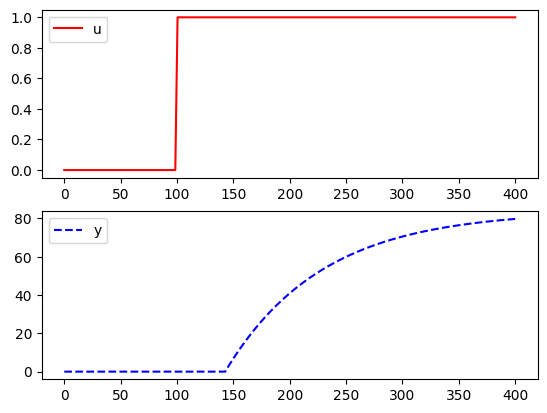

In [15]:
mv = m.u[0] # define the manipulated variable as the symbolic variable u[0]
cv = m.cv # define the controlled variable as the symbolic variable model.CV() from the function definition

# generate a step input
mv.value = np.zeros(k)
mv.value[50:] = 1

m.options.imode = 4 # refers to a dynamic simulation
m.options.nodes = 2 # collocation points to perform discrete simulation

m.solve() # solve the equations by simulating it

# plot the input and output
plt.subplot(2,1,1)
plt.plot(m.time,mv.value,'r-',label=r'u')
plt.legend()
plt.subplot(2,1,2)
plt.plot(m.time,cv.value,'b--',label=r'y')
plt.legend()
plt.show()


## Graphically identifying the model

There are different methods of idenitfication, but a simple graphcially method will be employed here.

 ----------------------------------------------------------------
 APMonitor, Version 1.0.3
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            2
   Constants    :            0
   Variables    :            4
   Intermediates:            0
   Connections  :            5
   Equations    :            0
   Residuals    :            0
 
 
 LTI Model Statistics
 -------------------------------------
 Sparse Matrices
 Continuous Form
 Matrix    Dimension    Non-zeros
   A                 1 x           1                 1
   B                 1 x           1                 1
   C                 1 x           1                 1
   D                 1 x           1                 0
   E                 1 x           1                 1
 -------------------------------------
 
 Number of state variables:           4577
 Number of total equations: -      

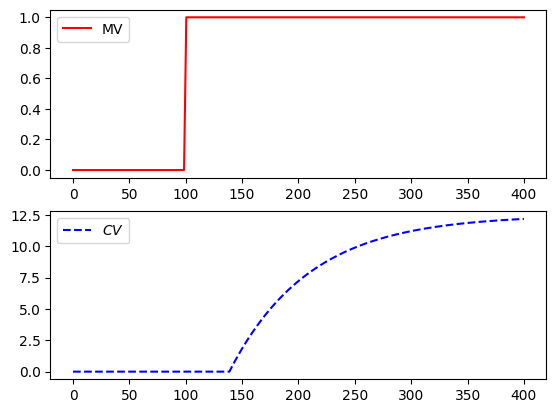

In [6]:
thetap = 40 # the time between the start of the step and the output responding (the inflection point)
Kp = 12.5 # the multiplication on the unit step response
tau = 70 # the time it takes the output to reach 63.2% of its saturation (starting at the inflection point)

k_identified = k

FOPDT_identified = HeatingModel(
        model_type="FOPDT", add_noise=False, sample_time=2, time_steps=k_identified
    )

FOPDT_identified.model.time_constant = tau
FOPDT_identified.model.gain = Kp
FOPDT_identified.model.dead_time = thetap

m_identified = FOPDT_identified.model.define_ss()

mv_identified = m_identified.u[0]
cv_identified = m_identified.cv

mv_identified.value = np.zeros(k_identified)
mv_identified.value[50:] = 1

m_identified.options.imode = 4
m_identified.options.nodes = 2

m_identified.solve()

plt.subplot(2,1,1)
plt.plot(m_identified.time,mv_identified.value,'r-',label=r'MV')
plt.legend()
plt.subplot(2,1,2)
plt.plot(m_identified.time,cv_identified.value,'b--',label=r'$CV$')
plt.legend()
plt.show()


## The big reveal for the graphical method

Now we can do what we wouldn't be able to in the real-world and see how far off our graphical approximation was...

In [7]:
# Print and round the values from FOPDT
print("FOPDT Model:")
print(f"Dead time: {round(FOPDT.model.dead_time, 1)}")
print(f"Gain: {round(FOPDT.model.gain, 1)}")
print(f"Time constant: {round(FOPDT.model.time_constant, 1)}")

# Print and round the values from FOPDT_identified
print("\nFOPDT Graphically Identified Model:")
print(f"Dead time: {round(FOPDT_identified.model.dead_time, 1)}")
print(f"Gain: {round(FOPDT_identified.model.gain, 1)}")
print(f"Time constant: {round(FOPDT_identified.model.time_constant, 1)}")

FOPDT Model:
Dead time: 40.9
Gain: 13.3
Time constant: 93.4

FOPDT Identified Model:
Dead time: 40
Gain: 12.5
Time constant: 70


# Identification with `GEKKO`

This method is an optimization technique which uses a symbolic model to identify the parameters of the `FODPT` model. It is also nice because it can take into account input delays (i.e., the dead time).

/var/folders/kg/8yp_xckj47ldc9fcxq73kchh0000gn/T/ipykernel_39398/3351780446.py:4: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  input = np.array(mv.value)
/var/folders/kg/8yp_xckj47ldc9fcxq73kchh0000gn/T/ipykernel_39398/3351780446.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  output = np.array(cv.value)


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(200,)
(200,)
(200,)
 ----------------------------------------------------------------
 APMonitor, Version 1.0.3
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            1
   Constants    :            0
   Variables    :            8
   Intermediates:            0
   Connections  :            2
   Equations    :            4
   Residuals    :            4
 
 Number of state variables:           1197
 Number of total equations: -         1194
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              3
 
 solver            3  not supported
 using default solver: APOPT
 ----------------------------------------------
 Dynamic Estimation with APOPT Solver
 ----------------------------------------------
 
 Iter    Objecti

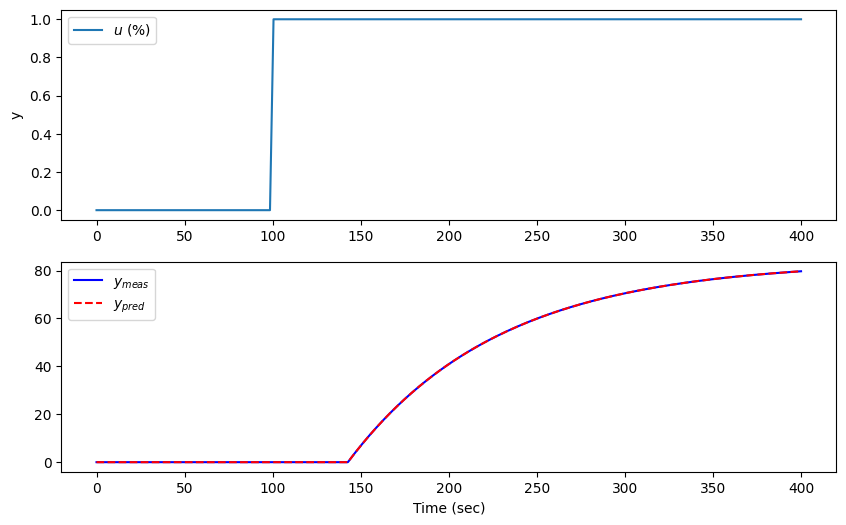

In [95]:
# load data
t = m.time

input = np.array(mv.value)
output = np.array(cv.value)

# generate time-series model
sysid_m = GEKKO(remote=False)
sysid_m.time = t; time = sysid_m.Var(0); sysid_m.Equation(time.dt()==1)

K = sysid_m.FV(50,lb=0,ub=100);      K.STATUS=1
tau = sysid_m.FV(50,lb=0,ub=100);  tau.STATUS=1
theta_ub = 50 # upper bound to dead-time
theta = sysid_m.FV(25,lb=0,ub=theta_ub); theta.STATUS=1

# add extrapolation points
td = np.concatenate((np.linspace(-theta_ub,min(t)-1e-5,5),t))
ud = np.concatenate((u[0]*np.ones(5),input))
# create cubic spline with t versus u
uc = sysid_m.Var(u); tc = sysid_m.Var(t); sysid_m.Equation(tc==time-theta)
sysid_m.cspline(tc,uc,td,ud,bound_x=False)

ym = sysid_m.Param(output); yp = sysid_m.Var(output)
sysid_m.Equation(tau*yp.dt()+(yp-y[0])==K*(uc-u[0]))

sysid_m.Minimize((yp-ym)**2)

sysid_m.options.IMODE=5
sysid_m.solve()

plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.plot(t,input)
plt.legend([r'$u$'])
plt.ylabel('y')
plt.subplot(2,1,2)
plt.plot(t,ym,'b-',label=r'$y_{meas}$')
plt.plot(t,yp,'r--',label=r'$y_{pred}$')
plt.legend()
plt.xlabel('Time (sec)')



## The big reveal for the optimization method

Now we can do what we wouldn't be able to in the real-world and see how far off our optimization was...

In [98]:
print("FOPDT Model:")
print(f"Dead time: {round(FOPDT.model.dead_time, 1)}")
print(f"Gain: {round(FOPDT.model.gain, 1)}")
print(f"Time constant: {round(FOPDT.model.time_constant, 1)}")


print("\nOptimally Identified FOPDT Model:")
print(f"Dead time: {round(theta.value[0], 1)}")
print(f"Gain: {round(K.value[0], 1)}")
print(f"Time constant: {round(tau.value[0], 1)}")


FOPDT Model:
Dead time: 45.7
Gain: 83.9
Time constant: 84.6

Optimally Identified FOPDT Model:
Dead time: 44.2
Gain: 83.9
Time constant: 84.6


# PID Control

Now that we have our roughly identified model, let's try to control it to a set-point with a PID